In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

import torch

import transformers
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from transformers import TrainingArguments

from peft import LoraConfig

from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from langchain.prompts import PromptTemplate

from IPython.display import Markdown, display

In [3]:
dataset = load_dataset("Babelscape/REDFM", language='all_languages')

In [4]:
len(dataset['train'])

10337

In [5]:
train_ds = dataset['train']
# dir(train_ds)
fr_train_ds = train_ds.filter(lambda example: example['lan'] == 'fr')
example = fr_train_ds[101]

In [6]:
len(fr_train_ds)

1865

In [7]:
example["relations"]

[{'subject': {'uri': 'Q2277',
   'surfaceform': 'impérial',
   'type': 'LOC',
   'start': 53,
   'end': 61},
  'predicate': 22,
  'object': {'uri': 'Q1747689',
   'surfaceform': 'Rome antique',
   'type': 'LOC',
   'start': 68,
   'end': 80}}]

In [8]:
example['text']

'La Domus aurea ou Maison dorée est un immense palais impérial de la Rome antique, construit pour Néron, qui couvrait une partie importante de Rome "intra muros" sur plusieurs dizaines d\'hectares. Elle doit son nom aux feuilles d\'or destinées à rehausser certains motifs du décor des fresques. Elle comportait plusieurs bâtiments distincts, de vastes jardins, un lac artificiel, mais aussi une salle de banquet qui tournait sur elle-même. Après la mort de Néron, l\'espace occupé fut rendu aux Romains et le Colisée fut édifié sur l\'emplacement du lac asséché. Ensevelie pendant des siècles, la "Domus aurea" fut en partie redécouverte à la Renaissance.'

In [9]:
for entity in example['entities']:
    print(entity['surfaceform'])

Domus aurea
impérial
Rome antique
Néron
Rome
intra muros
Colisée
Domus aurea
Renaissance


In [10]:
len(fr_train_ds)

1865

In [11]:
# RELATION_NAMES=['pays', 'lieu de naissance', 'conjoint', 'pays de nationalité', 'instance de',
#         'capital', 'enfant', 'partage la frontière avec', 'auteur', 'directeur', 'occupation',
#           'fondée par', 'ligue', 'appartenant à', 'genre', 'nommé d\'après', 'suit',
#             'localisation du siège social', 'membre du casting', 'constructeur',
#               'situé dans ou à côté d\'une étendue d\'eau', 'localisation', 'partie de', 
#               'embouchure du cours d\'eau', 'membre de', 'sport', 'caractères',
#                 'participant', 'travail remarquable', 'remplacer', 'frère et sœur', 'création']

In [12]:
def get_relation(example):

    RELATION_NAMES=['country', 'place of birth', 'spouse', 'country of citizenship', 'instance of',
            'capital', 'child', 'shares border with', 'author', 'director', 'occupation',
              'founded by', 'league', 'owned by', 'genre', 'named after', 'follows',
                'headquarters location', 'cast member', 'manufacturer',
                  'located in or next to body of water', 'location', 'part of', 
                  'mouth of the watercourse', 'member of', 'sport', 'characters',
                    'participant', 'notable work', 'replaces', 'sibling', 'inception']
    relations = []
    for relation in example['relations']:
        object = relation['object']['surfaceform']
        subject = relation['subject']['surfaceform']
        predicate = RELATION_NAMES[relation['predicate']]
        relations.append(f"[’{subject}’, ’{predicate}’, ’{object}’]")

 
    return ' | '.join(relations)

In [13]:
relations = get_relation(example)
relations

'[’impérial’, ’partie de’, ’Rome antique’]'

In [14]:
from langchain.prompts import PromptTemplate

rel_template = """Vous êtes un expert en data science et en traitement du langage naturel(NLP).
Votre tâche consiste à extraire les triplets du TEXTE fourni ci-dessous.
Un triplet de connaissances est constitué de 2 entités (sujet et objet) liées par un prédicat : 
['sujet', 'prédicat', 'objet'].
Les triples multiples doivent être séparés par ' | '.\n
TEXTE: {text}\n
Relations: {answer}"""

rel_prompt = PromptTemplate(template=rel_template, input_variables=['text', 'answer'])

display(Markdown(rel_prompt.format(text=example['text'], 
                               answer=get_relation(example))))

Vous êtes un expert en data science et en traitement du langage naturel(NLP).
Votre tâche consiste à extraire les triplets du TEXTE fourni ci-dessous.
Un triplet de connaissances est constitué de 2 entités (sujet et objet) liées par un prédicat : 
['sujet', 'prédicat', 'objet'].
Les triples multiples doivent être séparés par ' | '.

TEXTE: La Domus aurea ou Maison dorée est un immense palais impérial de la Rome antique, construit pour Néron, qui couvrait une partie importante de Rome "intra muros" sur plusieurs dizaines d'hectares. Elle doit son nom aux feuilles d'or destinées à rehausser certains motifs du décor des fresques. Elle comportait plusieurs bâtiments distincts, de vastes jardins, un lac artificiel, mais aussi une salle de banquet qui tournait sur elle-même. Après la mort de Néron, l'espace occupé fut rendu aux Romains et le Colisée fut édifié sur l'emplacement du lac asséché. Ensevelie pendant des siècles, la "Domus aurea" fut en partie redécouverte à la Renaissance.

Relations: [’impérial’, ’partie de’, ’Rome antique’]

In [15]:
import json

output = []
for entry in fr_train_ds:
    output.append({"instruction": """Vous êtes un expert en data science et en traitement du langage naturel(NLP). Votre tâche consiste à extraire les triplets du TEXTE fourni ci-dessous. Un triplet de connaissances est constitué de 2 entités (sujet et objet) liées par un prédicat : ['sujet', 'prédicat', 'objet']. Les triples multiples doivent être séparés par ' | '.\n""",
                    "input": entry['text'],
                    "output": get_relation(entry)})
# Serializing json
# json_object = json.dumps(output, indent=4)
 
# Writing to sample.json
with open("../../data/REDFM_fr.json", "w") as outfile:
    # outfile.write(json_object)
    json.dump(output, outfile, indent=4, ensure_ascii=False)

In [16]:
len(output)

1865

In [17]:
def format_text(example):
    text = rel_prompt.format(
        text=example['text'], 
        answer=get_relation(example))
    return {"text": text}

In [18]:
data = fr_train_ds.map(format_text)
data

Dataset({
    features: ['docid', 'title', 'uri', 'lan', 'text', 'entities', 'relations'],
    num_rows: 1865
})

In [20]:
data[0]

{'docid': '4927370-0',
 'title': 'Chypre du Nord',
 'uri': 'Q23681',
 'lan': 'fr',
 'text': "Vous êtes un expert en data science et en traitement du langage naturel(NLP).\nVotre tâche consiste à extraire les triplets du TEXTE fourni ci-dessous.\nUn triplet de connaissances est constitué de 2 entités (sujet et objet) liées par un prédicat : \n['sujet', 'prédicat', 'objet'].\nLes triples multiples doivent être séparés par ' | '.\n\nTEXTE: Chypre du Nord et, en forme longue, la république turque de Chypre du Nord (dénomination abrégée en RTCN), en turc (abrégé en ou en ), est un État reconnu uniquement par la Turquie et, un temps, par le Pakistan, situé dans la partie nord-est de l'île de Chypre. Elle a proclamé son indépendance le , neuf ans après l'intervention militaire turque de 1974, alors en réaction à la tentative de rattachement de l'île à la Grèce par un groupe d'officiers putschistes de la garde nationale chypriote (l'EOKA B) mené par Níkos Sampsón après le renversement du prési

In [21]:
def plot_sequence_lengths(data, split='train', max_length=2048):
    sequence_lengths = []
    keep_indices = []

    # Loop over the dataset and get the lengths of text sequences
    # for i, example in enumerate(data[split]):
    for i, example in enumerate(data):
        sequence_lengths.append(len(example['text']))
        if sequence_lengths[i] < max_length:
            keep_indices.append(i)

    # Plot the histogram
    plt.hist(sequence_lengths, bins=30)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Sequence Lengths')
    plt.show()

    return keep_indices

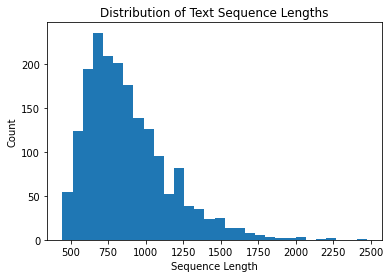

In [22]:
keep_indices_train = plot_sequence_lengths(data)

In [23]:
data = data.select(keep_indices_train)

In [24]:
len(data)

1860

In [25]:
model_id = "bofenghuang/vigo-mistral-7b-chat"

In [26]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [27]:
qlora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    # target_modules=["query_key_value", "dense", "dense_h_to_4h", "dense_4h_to_h"],
    target_modules=["Wqkv", "out_proj", "fc1", "fc2"],
    task_type="CAUSAL_LM"
)

bnb_config = BitsAndBytesConfig(
    # load_in_8bit=True,
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    trust_remote_code=True,
)


In [29]:
base_model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )

In [26]:
# shitty hack
# TODO get the new mixformer class from huggingface, it works with "gradient_checkpointing_enable"
def gradient_checkpointing_enable():
    pass

base_model.gradient_checkpointing_enable = gradient_checkpointing_enable

In [28]:
training_args = TrainingArguments(
    output_dir="./SFT-phi-1p5b", 
    per_device_train_batch_size=1,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,
    learning_rate=2e-4,
    logging_steps=10,
    logging_strategy="steps",
    max_steps=4000,
    optim="paged_adamw_8bit",
    fp16=True,
    run_name="baseline-phi-sft"
)

In [21]:
data[0]

{'docid': '4927370-0',
 'title': 'Chypre du Nord',
 'uri': 'Q23681',
 'lan': 'fr',
 'text': "Vous êtes un expert en data science et en traitement du langage naturel(NLP).\nVotre tâche consiste à extraire les triplets du TEXTE fourni ci-dessous.\nUn triplet de connaissances est constitué de 2 entités (sujet et objet) liées par un prédicat : \n['sujet', 'prédicat', 'objet'].\nLes triples multiples doivent être séparés par ' | '.\n\nTEXTE: Chypre du Nord et, en forme longue, la république turque de Chypre du Nord (dénomination abrégée en RTCN), en turc (abrégé en ou en ), est un État reconnu uniquement par la Turquie et, un temps, par le Pakistan, situé dans la partie nord-est de l'île de Chypre. Elle a proclamé son indépendance le , neuf ans après l'intervention militaire turque de 1974, alors en réaction à la tentative de rattachement de l'île à la Grèce par un groupe d'officiers putschistes de la garde nationale chypriote (l'EOKA B) mené par Níkos Sampsón après le renversement du prési

In [29]:
supervised_finetuning_trainer = SFTTrainer(
    base_model,
    # train_dataset=data["train"],
    train_dataset=data,
    args=training_args,
    tokenizer=tokenizer,
    peft_config=qlora_config,
    dataset_text_field="text",
    max_seq_length=2048,
    data_collator=DataCollatorForCompletionOnlyLM(tokenizer=tokenizer, 
                                                  response_template="Relations:")
                                                #   response_template="Answer:")
)

/home/kkondratenko/python_envs/P310_general/lib/python3.10/site-packages/peft/utils/other.py:122: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
Loading cached processed dataset at /home/kkondratenko/.cache/huggingface/datasets/Babelscape___redfm/default-language=all_languages/1.0.0/576b7e6025452757ea5242348575c40d8d8c8d333b50445bc5909cde4bd903ee/cache-7600d89f7148dec0.arrow


In [30]:
supervised_finetuning_trainer.train()

You're using a CodeGenTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


TrainOutput(global_step=4000, training_loss=0.1438879871368408, metrics={'train_runtime': 9452.9583, 'train_samples_per_second': 0.846, 'train_steps_per_second': 0.423, 'total_flos': 8837084005146624.0, 'train_loss': 0.1438879871368408, 'epoch': 2.79})

In [31]:
supervised_finetuning_trainer.save_model('./adapter_phi_re')

In [1]:
model_id = "microsoft/phi-1_5"

In [5]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    # load_in_4bit=True,
    # quantization_config=bnb_config,
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)#.cuda()


In [19]:
# from peft import PeftConfig

adapter_model_id = "./adapter_phi_re"
# peft_config = PeftConfig.from_pretrained(adapter_model_id)

In [20]:
from peft import PeftModel 


model = PeftModel.from_pretrained(model, adapter_model_id)


In [10]:
from transformers import pipeline

pipeline_peft = pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer,
            # torch_dtype=torch.bfloat16,
            # generation_config=gen_cfg,
            temperature=0.0001,
            trust_remote_code=True,
            device_map="auto",
            return_full_text=False,
            do_sample=True,
            top_k=10,
            num_return_sequences=1,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,
        )

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayerN

In [16]:
rel_prompt.format(text=example['text'], 
                               answer=get_relation(example))

'You are an AI expert in data science and natural language processing.\nYour task is to extract the knowledge triplets from the TEXT provided below.\nA knowledge triplet consists of 2 entities (subject and object) linked by a predicate: \n[’subject’, ’predicate’, ’object’].\nMultiple triples must be separated with \' | \'\n\nTEXT: La Domus aurea ou Maison dorée est un immense palais impérial de la Rome antique, construit pour Néron, qui couvrait une partie importante de Rome "intra muros" sur plusieurs dizaines d\'hectares. Elle doit son nom aux feuilles d\'or destinées à rehausser certains motifs du décor des fresques. Elle comportait plusieurs bâtiments distincts, de vastes jardins, un lac artificiel, mais aussi une salle de banquet qui tournait sur elle-même. Après la mort de Néron, l\'espace occupé fut rendu aux Romains et le Colisée fut édifié sur l\'emplacement du lac asséché. Ensevelie pendant des siècles, la "Domus aurea" fut en partie redécouverte à la Renaissance.\n\nRelation

In [17]:
# proompt = rel_prompt.format(text=example['text'], 
#                                answer="")
# proompt = rel_prompt.format(text="Philz is a coffee shop founded in Berkeley in 1982.", 
#                                answer="")
proompt = rel_prompt.format(text="In the bustling streets of the ancient city, the skilled blacksmith crafted a magnificent sword, which soon became the talk of the town.", 
                               answer="")

In [23]:
# pipeline_peft(proompt)

In [8]:
from transformers import GenerationConfig
def generate_text(query):
    gen_cfg = GenerationConfig.from_model_config(model.config)
    # gen_cfg.max_new_tokens = DEFAULT_MAX_LENGTH
    # gen_cfg.temperature = 0.51
    gen_cfg.num_return_sequences = 1
    gen_cfg.use_cache = True
    gen_cfg.min_length = 1

    inputs = tokenizer(query, 
                       return_tensors="pt", 
                       return_attention_mask=False)#.to('cuda')
    outputs = model.generate(
        **inputs,
        max_length=512, 
        generation_config=gen_cfg,
        do_sample=True, 
        temperature=0.01, 
        top_p=0.9, 
        # use_cache=True, 
        repetition_penalty=1.2, 
        eos_token_id=tokenizer.eos_token_id)
    text = tokenizer.batch_decode(outputs)[0]
    return text

In [19]:
resp = generate_text(proompt)

print(resp)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


You are an AI expert in data science and natural language processing.
Your task is to extract the knowledge triplets from the TEXT provided below.
A knowledge triplet consists of 2 entities (subject and object) linked by a predicate: 
[’subject’, ’predicate’, ’object’].
Multiple triples must be separated with'| '

TEXT: In the bustling streets of the ancient city, the skilled blacksmith crafted a magnificent sword, which soon became the talk of the town.

Relations: 
- Subject : The blacksmith
  Predicate : Crafted a majestic sword
  Object : A magnificent weapon that captivated everyone's attention

<|endoftext|>
